# НИР. Множественное выравнивание границ экзон-интрон и интрон-экзон

## 2. Графики распределений


1. Подсчет количества каждого нуклеотида в столбце, $m_i^j$, и общего числа нуклеотидов в столбце $M(i) = \sum_{j=1}^{4}{m_i^j}$, <p>где $ j = \{A, G, T, C\}, \: i = 1..100$;</p>
2. Зануление разреженных столбцов при условии $M(i) < \frac{L}{2}$, где L - количество последовательностей. Получим новую длину последовательностей;
3. Подсчет общего количества нуклеотидов N и вероятностей для каждого в отдельности: $P_i = \frac{n_i}{N}$, <p>где $n_i = \sum_{j=0}^{j=N}{m_i^j}, \: i = \{A, G, T, C\}$;</p>
4. Подсчет хи-квадрат величины:
$$
\chi^2(i) = \sum_{j=1}^{j=4} \frac{(m_j^i - M(i)P_j)^2}{M(i)P_j}
$$

5. Перемешать нуклеотиды и посчитать фоновый шум.






В силу центральной предельной теоремы, при большом числе степеней свободы распределение случайной величины $Y \sim \chi^{2}(k)$ может быть приближено нормальным $ Y \approx N(k,2k)$. Более точно $ \frac{Y - k}{\sqrt{2k}} \to N(0,1)$ по распределению при $ k \to \infty $.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.stats import chi2, gaussian_kde

##### Функции подсчета сл.величины


In [2]:
# Чтение и обработка файла

def preproc(file_name):
    with open(file_name, 'r') as file:
        lines = ''.join(file.readlines()[2:-1]).split('\n')
        lines = ''.join(lines).split('JJ')[1:]
    
    for i in range(len(lines)):
        lines[i] = lines[i].split(' ')[-1]

    return lines

In [3]:
# Подсчет частот

def frequancy(lines):
    line_len = len(lines[0])
    freq_arr = np.zeros((4, line_len))

    for line in lines:
        for i in range(line_len):
            if line[i] == 'A':
                freq_arr[0][i] += 1
            elif line[i] == 'G':
                freq_arr[1][i] += 1
            elif line[i] == 'T':
                freq_arr[2][i] += 1
            elif line[i] == 'C':
                freq_arr[3][i] += 1
    
    return freq_arr

In [4]:
# Подсчет вероятностей

def probability(freq_arr):
    N = freq_arr.sum(axis=0).sum()
    n = freq_arr.sum(axis=1)

    return  n / N

In [5]:
# Зануление разреженных столбцов

def clean_data(lines, freq_arr):
    M = freq_arr.sum(axis=0)
    L = len(lines)

    M = np.where(M <= L / 2, 0, M)
    freq_arr = np.where(M == 0, 0, freq_arr)

    # indexes = np.argwhere(M == 0).flatten()

    # indexes_to_drop = np.argwhere(M <= L / 2).flatten()

    # data = np.array(list(''.join(lines))).reshape(len(lines), len(lines[0]))

    # freq_arr = np.delete(freq_arr, indexes_to_drop, 1)
    # data     = np.delete(data, indexes_to_drop, 1)

    return freq_arr

In [6]:
# Распределение хи-квадрат

def chi_square_dist(freq_arr_clear, prob):
    M = freq_arr_clear.sum(axis=0)

    MP = prob.reshape(-1, 1).dot(M.reshape(1, M.shape[0]))

    X = np.where(M == 0, 0, (freq_arr_clear - MP)**2 / MP)
    return X.sum(axis=0)

In [7]:
def main_normal(lines):    
    # подсчет частот в каждой позиции
    freq_arr = frequancy(lines)

    # зануление разреженных столбцов
    freq_arr_clear = clean_data(lines, freq_arr)

    # подсчет вероятностей
    prob = probability(freq_arr_clear)

    # распределение хи-квадрат
    chi_square = chi_square_dist(freq_arr_clear, prob)
    
    # Сведение к нормальной величине
    df = 3      # степеней свободы 
    normal_arg = (chi_square - df) / np.sqrt(2 * df)

    return normal_arg

In [8]:
def main(file):
    # преобработка            
    lines = preproc(file)
    normal_arg = main_normal(lines)
    
    return normal_arg

In [9]:
def main_noise(file):
    # преобработка
    lines = preproc(file)
    
    count_lines = len(lines)
    line_len = len(lines[0])
    lines = ''.join(lines)

    data_shuffled = list(''.join(lines.split('.')))
    lines = list(lines)

    np.random.shuffle(data_shuffled)

    index = 0
    for i in range(len(lines)):
        if lines[i] != '.':
            lines[i] = data_shuffled[index]
            index += 1

    lines = np.array(lines).reshape(count_lines, line_len)
    lines = [''.join(line) for line in lines]

    normal_arg_noise = main_normal(lines)
    
    return normal_arg_noise

In [10]:
def value_plotting(values, labels, title, file_name, target_path):
    normal_arg = values[0]
    normal_arg_noise_1 = values[1]
    normal_arg_noise_2 = values[2]
    
    label = labels[0]
    label_noise_1 = labels[1]
    label_noise_2 = labels[2]
    
    # Параметры графика
    fontsize = 18
    fig, axes = plt.subplots(2, 1, figsize=(20,15))

#     # общий график
#     axes[0].set_ylabel('$Y$', fontsize=fontsize)
#     axes[0].plot(normal_arg, label=label)
# #     axes[0].plot(normal_arg_noise, label=label_noise)
#     axes[0].legend(fontsize=fontsize*0.6)
    
#     major_ticks_x = np.arange(0, len(normal_arg), 5)
#     minor_ticks_x = np.arange(0, len(normal_arg), 2.5)    
#     axes[0].set_xticks(major_ticks_x)
#     axes[0].set_xticks(minor_ticks_x, minor=True)
    
    # График в заданных диапазонах
    major_ticks_x = np.arange(0, len(normal_arg), 5)
    minor_ticks_x = np.arange(0, len(normal_arg), 2.5)
    major_ticks_y = np.arange(-50, 51, 2)
    # minor_ticks_y = np.arange(0, 101, 2)

    for i in range(0,2):
        axes[i].set_xticks(major_ticks_x)
        axes[i].set_xticks(minor_ticks_x, minor=True)
        axes[i].set_yticks(major_ticks_y)
        # ax.set_yticks(minor_ticks_y, minor=True)

        axes[i].set_ylim(-6, 8)
        axes[i].set_ylabel('$Y$', fontsize=fontsize)
        axes[i].grid(which='both')

    if file_name.split('_')[0] == 'exon':
        if len(normal_arg) >= 100:
            bottom = 58
            top = 47    
        else:
            bottom = 31
            top = 21
    else:
        if len(normal_arg) >= 100:
            bottom = 53
            top = 43
        else:
            bottom = 28
            top = 18

    axes[0].set_title(title, fontsize=fontsize)

    axes[0].plot(normal_arg[0:top],         label=label)
    axes[0].plot(normal_arg_noise_1[0:top], label=label_noise_1)
    axes[0].plot(normal_arg_noise_2[0:top], label=label_noise_2)

    axes[0].set_xlabel('Позиции в последовательности (до границы)', fontsize=fontsize)
    axes[0].legend(fontsize=fontsize*0.8)
    axes[0].tick_params(axis='both', which='major', labelsize=fontsize*0.8)
    

    axes[1].plot(range(bottom, len(normal_arg)), normal_arg[bottom:],         label=label)
    axes[1].plot(range(bottom, len(normal_arg)), normal_arg_noise_1[bottom:], label=label_noise_1)
    axes[1].plot(range(bottom, len(normal_arg)), normal_arg_noise_2[bottom:], label=label_noise_2)

    axes[1].set_xlabel('Позиции в последовательности (после границы)', fontsize=fontsize)
    axes[1].legend(fontsize=fontsize*0.8)
    axes[1].tick_params(axis='both', which='major', labelsize=fontsize*0.8)

#     axes[1].annotate(s='Y ~ N(0, 1) - нормально распределенная случайная величина', xy=(65, -10), annotation_clip=False, fontsize=fontsize)
#     axes[1].annotate(s=f'Размер выборки {len(lines)} последовательностей', xy=(65, -11), annotation_clip=False, fontsize=fontsize)
#     axes[1].annotate(s=f'Длина выровненных последовательностей {len(normal_arg)}', xy=(65, -12), annotation_clip=False, fontsize=fontsize)

    plt.show
    plt.savefig(target_path + f'{file_name}.jpeg', bbox_inches='tight')

##### Построение графиков

In [11]:
files_path = 'C:/Users/kshch/Projects/УИР/src/data/methods/mahds/align/datasets/sto/'
target_path = 'C:/Users/kshch/Projects/УИР/src/data/methods/mahds/distribution/'

intron_exon_forward_200_30.sto
110


<ipython-input-6-9e2464e20c6c>:8: RuntimeWarning: invalid value encountered in true_divide
  X = np.where(M == 0, 0, (freq_arr_clear - MP)**2 / MP)


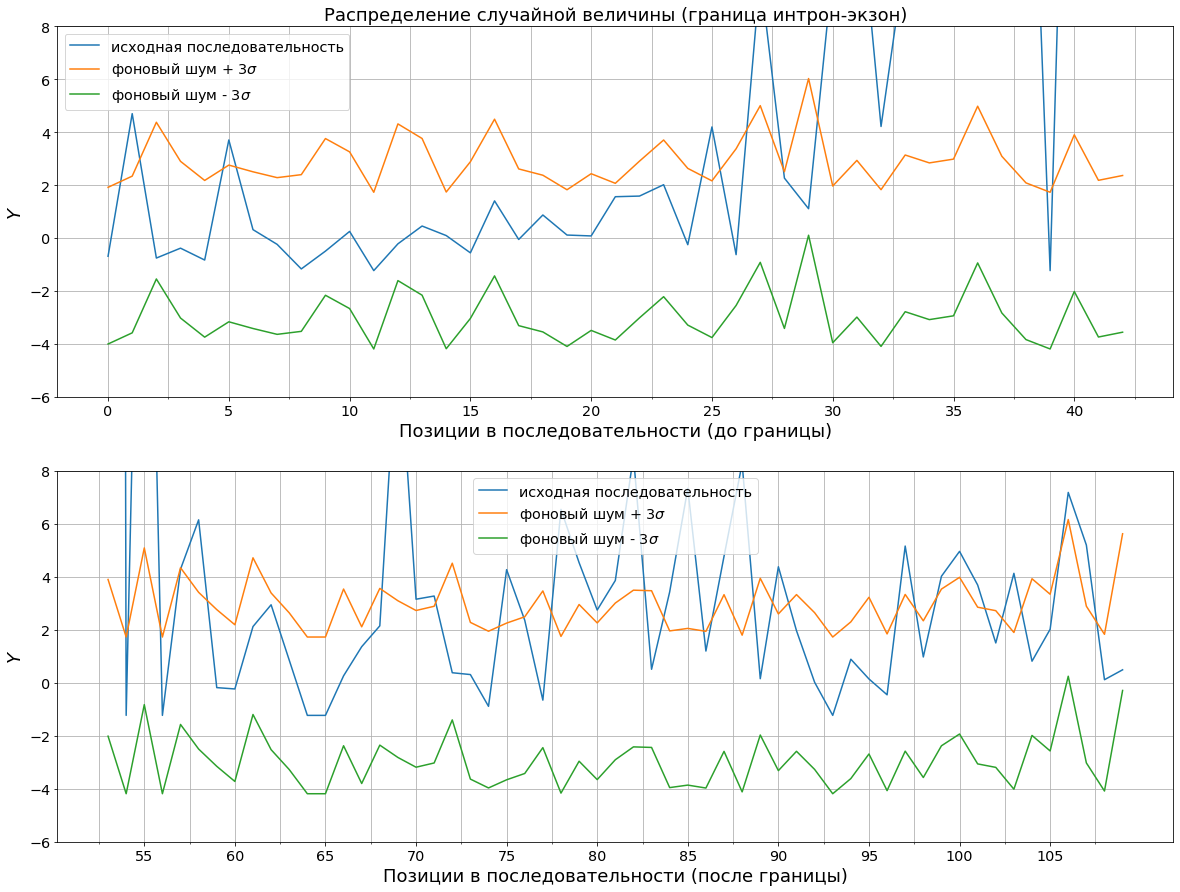

In [12]:
label = 'исходная последовательность'
label_noise_1 = 'фоновый шум + $3\sigma$'
label_noise_2 = 'фоновый шум - $3\sigma$'

os.chdir(r"{}".format(files_path))

# for file in os.listdir():
file = 'intron_exon_forward_200_30.sto'
print(file)
file_name = file.split('.')[0]
title = ''

if file.split('_')[0] == 'exon':
    title = 'Распределение случайной величины (граница экзон-интрон)'
else:
    title = 'Распределение случайной величины (граница интрон-экзон)'


# нормальное распределение
normal_arg = main(file)
normal_arg_noise = main_noise(file)

print(len(normal_arg))


# фоновый шум
std_noise = np.std(normal_arg_noise)
normal_arg_noise_1 = normal_arg_noise + 3 * std_noise
normal_arg_noise_2 = normal_arg_noise - 3 * std_noise

# график
value_plotting(values=[normal_arg, normal_arg_noise_1, normal_arg_noise_2], 
               labels=[label, label_noise_1, label_noise_2], 
               title=title, file_name=file_name, target_path=target_path)

In [13]:
# files_path = 'C:/Users/kshch/Projects/УИР/src/data/methods/mahds/align/sto/len_100/'
# target_path = 'C:/Users/kshch/Projects/УИР/src/data/methods/mahds/distribution/len_100/'

In [14]:
# label = 'исходная последовательность'
# label_noise_1 = 'фоновый шум + $3\sigma$'
# label_noise_2 = 'фоновый шум - $3\sigma$'

# os.chdir(r"{}".format(files_path))

# for file in os.listdir():
#     print(file)
#     file_name = file.split('.')[0]
#     title = ''

#     if file.split('_')[0] == 'exon':
#         title = 'Распределение случайной величины (граница экзон-интрон)'
#     else:
#         title = 'Распределение случайной величины (граница интрон-экзон)'


#     # нормальное распределение
#     normal_arg = main(file)
#     normal_arg_noise = main_noise(file)

#     print(len(normal_arg))
    
#     # фоновый шум
#     std_noise = np.std(normal_arg_noise)
#     normal_arg_noise_1 = normal_arg_noise + 3 * std_noise
#     normal_arg_noise_2 = normal_arg_noise - 3 * std_noise

#     # график
#     value_plotting(values=[normal_arg, normal_arg_noise_1, normal_arg_noise_2], 
#                    labels=[label, label_noise_1, label_noise_2], 
#                    title=title, file_name=file_name, target_path=target_path)